Copyright (C) 2022 Jørgen Schartum Dokken

This file is part of Oasisx
SPDX-License-Identifier:    MIT

# Efficient assembly
This demo illustrates the performance differences between matrix free and cached assembly
for the Crank Nicholson time discretization with the implicit Adams-Bashforth linearization
in the tentative velocity step of the Navier-Stokes Equation.

We start by importing the necessary modules

In [1]:
import seaborn
import pandas
import dolfinx
import dolfinx.fem.petsc
from mpi4py import MPI
from petsc4py import PETSc
import ufl
import numpy as np

We define a function, that takes in a mesh, the order `P` of the Lagrange function space for the
scalar component of the velocity field, the number of times we should time the assembly, and
`jit_options` for just in time compilation of the vartiational forms.

For the *Matrix-vector* strategy, we do only time the time it takes to modify the pre-assembled
convection matrix, adding the scaled mass and stiffness matrices and computing the matrix vector
product, as the matrix `A` is needed for the LHS assembly in the fractional step method.

For the *Action strategy* we use `ufl.action` to create the variational form for the RHS
vector, and use generated code for the assembly.

This demo does not consider any Dirichet boundary conditions.

We add some arbitrary data to the variables `dt`, `nu`, `u_1` and `u_ab`,
as we are not solving a full problem here.

In [2]:
def assembly(mesh, P: int, repeats: int, jit_options: dict = None):
    V = dolfinx.fem.FunctionSpace(mesh, ("CG", int(P)))
    dt = 0.5
    nu = 0.3
    u = ufl.TrialFunction(V)
    v = ufl.TestFunction(V)

    # Solution from previous time step
    u_1 = dolfinx.fem.Function(V)
    u_1.interpolate(lambda x: np.sin(x[0])*np.cos(x[1]))

    # Define variational forms
    mass = ufl.inner(u, v) * ufl.dx
    stiffness = ufl.inner(ufl.grad(u), ufl.grad(v)) * ufl.dx

    u_ab = [dolfinx.fem.Function(V, name=f"u_ab{i}") for i in range(mesh.geometry.dim)]
    convection = ufl.inner(ufl.dot(ufl.as_vector(u_ab), ufl.nabla_grad(u)), v) * ufl.dx
    for u_abi in u_ab:
        u_abi.interpolate(lambda x: x[0])

    # Compile forms for matrix vector products
    jit_options = {} if jit_options is None else jit_options
    mass_form = dolfinx.fem.form(mass, jit_options=jit_options)
    stiffness_form = dolfinx.fem.form(stiffness, jit_options=jit_options)
    convection_form = dolfinx.fem.form(convection, jit_options=jit_options)

    # Compile form for vector assembly (action)
    dt_inv = dolfinx.fem.Constant(mesh, 1./dt)
    dt_inv.name = "dt_inv"
    nu_c = dolfinx.fem.Constant(mesh, nu)
    nu_c.name = "nu"
    lhs = dt_inv * mass - 0.5 * nu_c * stiffness - 0.5*convection
    lhs = dolfinx.fem.form(ufl.action(lhs, u_1), jit_options=jit_options)

    # Assemble time independent matrices
    # Mass matrix
    M = dolfinx.fem.petsc.create_matrix(mass_form)
    M.setOption(PETSc.Mat.Option.SYMMETRIC, True)
    M.setOption(PETSc.Mat.Option.SYMMETRY_ETERNAL, True)
    M.setOption(PETSc.Mat.Option.IGNORE_ZERO_ENTRIES, True)
    dolfinx.fem.petsc.assemble_matrix(M, mass_form)
    M.assemble()
    M.setOption(PETSc.Mat.Option.NEW_NONZERO_LOCATIONS, False)

    # Stiffness matrix
    K = dolfinx.fem.petsc.create_matrix(stiffness_form)
    K.setOption(PETSc.Mat.Option.SYMMETRIC, True)
    K.setOption(PETSc.Mat.Option.SYMMETRY_ETERNAL, True)
    K.setOption(PETSc.Mat.Option.IGNORE_ZERO_ENTRIES, True)
    dolfinx.fem.petsc.assemble_matrix(K, stiffness_form)
    K.assemble()
    K.setOption(PETSc.Mat.Option.NEW_NONZERO_LOCATIONS, False)

    # Create time dependent matrix (convection matrix)
    A = dolfinx.fem.petsc.create_matrix(mass_form)
    A.setOption(PETSc.Mat.Option.IGNORE_ZERO_ENTRIES, True)

    # Vector for matrix vector product
    b = dolfinx.fem.Function(V)

    t_matvec = np.zeros((repeats, mesh.comm.size), dtype=np.float64)
    t_action = np.zeros((repeats, mesh.comm.size), dtype=np.float64)
    for i in range(repeats):
        # Zero out time-dependent matrix
        A.zeroEntries()

        # Add convection term
        dolfinx.fem.petsc.assemble_matrix(A, convection_form)
        A.assemble()

        # Do mat-vec operations
        with dolfinx.common.Timer(f"~{P} {i} Matvec strategy") as _:
            A.scale(-0.5)
            A.axpy(1./dt, M)
            A.axpy(-0.5*nu, K)
            A.mult(u_1.vector, b.vector)
            b.x.scatter_forward()

        # Compute the vector without using pre-generated matrices
        b_d = dolfinx.fem.Function(V)
        with dolfinx.common.Timer(f"~{P} {i} Action strategy") as _:
            dolfinx.fem.petsc.assemble_vector(b_d.vector, lhs)
            b_d.x.scatter_reverse(dolfinx.la.InsertMode.add)
            b_d.x.scatter_forward()
        # Compare results
        assert np.allclose(b.x.array, b_d.x.array)

        # Get timings
        matvec = dolfinx.common.timing(f"~{P} {i} Matvec strategy")
        action = dolfinx.common.timing(f"~{P} {i} Action strategy")
        t_matvec[i, :] = mesh.comm.allgather(matvec[1])
        t_action[i, :] = mesh.comm.allgather(action[1])

    return V.dofmap.index_map_bs * V.dofmap.index_map.size_global, t_matvec, t_action

We solve the problem on a unit cube that is split into tetrahedras with `Nx`,`Ny` and `Nx`
tetrahera in the x, y and z-direction respectively.

In [3]:
def run_parameter_sweep(Nx: int, Ny: int, Nz: int, repeats: int, min_degree: int,
                        max_degree: int) -> dict:
    # Information regarding optimization flags can be found at:
    # https://gcc.gnu.org/onlinedocs/gcc/Optimize-Options.html
    jit_options = {"cffi_extra_compile_args": ["-march=native", "-O3"]}

    mesh = dolfinx.mesh.create_unit_cube(MPI.COMM_WORLD, Nx, Ny, Nz)
    Ps = np.arange(min_degree, max_degree+1, dtype=np.int32)
    j = 0
    results = {}
    for i, P in enumerate(Ps):
        dof, matvec, action = assembly(mesh, P, repeats=repeats, jit_options=jit_options)
        for row in matvec:
            for process in row:
                results[j] = {"P": P, "num_dofs": dof, "method":
                              "matvec", "time (s)": process, "procs": MPI.COMM_WORLD.size}
                j += 1
        for row in action:
            for process in row:
                results[j] = {"P": P, "num_dofs": dof, "method":
                              "action", "time (s)": process, "procs": MPI.COMM_WORLD.size}
                j += 1
    return results

We use `pandas` and `seaborn` to visualize the results

In [4]:

def create_plot(results: dict, outfile: str):
    if MPI.COMM_WORLD.rank == 0:
        df = pandas.DataFrame.from_dict(results, orient="index")
        df["label"] = "P" + df["P"].astype(str) + " " + \
            df["num_dofs"].astype(str) + " \n Comms: " + df["procs"].astype(str)
        plot = seaborn.catplot(data=df, kind="swarm",  x="label", y="time (s)", hue="method")
        plot.set(yscale="log")
        import matplotlib.pyplot as plt
        plt.grid()
        plt.savefig(outfile)

We start by running the comparison for an increasing number of degrees of freedom on a fixed grid.

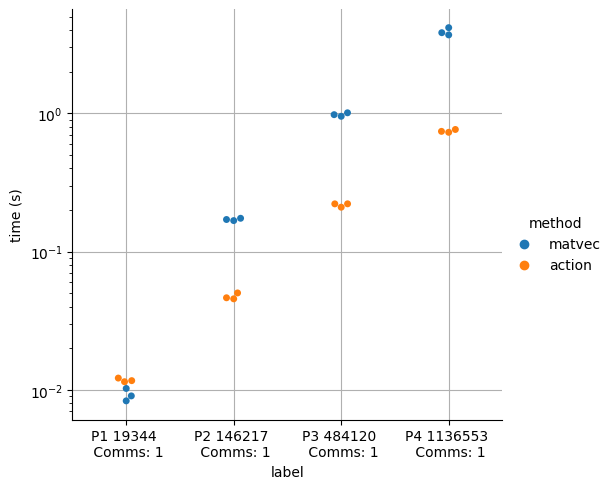

In [5]:
if __name__ == "__main__":
    results_p = run_parameter_sweep(30, 25, 23, repeats=3, min_degree=1, max_degree=4)
    create_plot(results_p, "P_sweep.png")

We observe that for all the runs, independent of the degree $P$, the *Action Strategy* is
significantly faster than the

We note that the run for $P=1$ is relatively small, and therefore run $P=1$ on a larger mesh

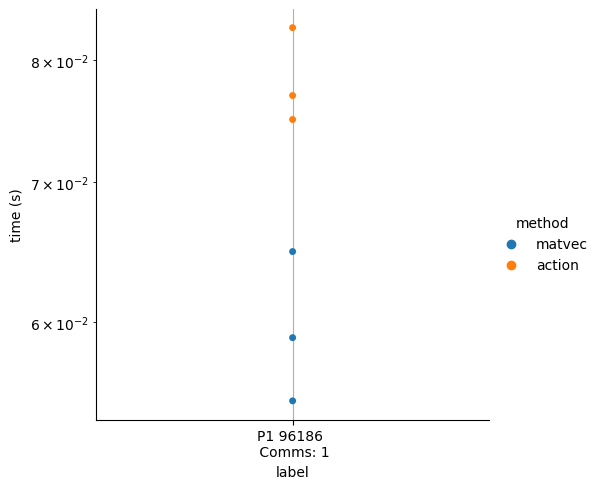

In [6]:
if __name__ == "__main__":
    results_p1 = run_parameter_sweep(50, 40, 45, 3, 1, 1)
    create_plot(results_p1, "P1.png")

We observe that the run-time of both strategies for $P = 1$ are more or less the
same for larger matrices.